In [1]:
import os, sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import MaaSSim

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
#!pip install MaaSSim
import MaaSSim.utils
import logging
from dotmap import DotMap
import MaaSSim.simulators
from MaaSSim.data_structures import structures as inData
from MaaSSim.day_to_day import driver_opt_out, S_driver_opt_out, traveller_opt_out, S_traveller_opt_out
from MaaSSim.day_to_day import traveller_opt_out
from MaaSSim.day_to_day import d2d_kpi_veh
from MaaSSim.day_to_day import d2d_kpi_pax

In [4]:
import osmnx as ox
import networkx as nx
import random
import math
import pandas as pd
import matplotlib.pyplot as plt          
import numpy as np
import seaborn as sns
from statsmodels.tsa.stattools import adfuller

In [5]:
params = MaaSSim.utils.get_config('glance.json')
params.city = "Amsterdam, Netherlands"
params.paths.G = "../../data/graphs/Amsterdam.graphml"
params.paths.skim = "../../data/graphs/Amsterdam.csv"
params.vehicle_fixed_positions = True
params.times.patience = 600 #second
params.dist_threshold = 20000 #meter
params.dist_threshold_min = 3000 #meter

params.d2d.probabilistic = True
params.d2d.heterogeneous = False
params.proportional_std = 0.1 # proportional standard deviation [0.1, 0.2, 0.3] for both VoT & RW distributions
params.d2d.ini_att = 0.01
params.d2d.B_income = 1

params.d2d.B_inveh_time = 1
params.d2d.B_exp_time = 2 #1.5 in Oded's paper
params.PT_fare = 1 ## euro
params.PT_avg_speed = 6

params.nPM = 1 # number of platforms. platform id starts from 1
params.platforms.base_fare = 1.4 #euro 
params.platforms.fare = float(1.8)# float(1.20) #euro/km #http://taxihowmuch.com/
params.platforms.min_fare = float(4) # euro #http://taxihowmuch.com/
params.d2d.fuel_cost = 0.25 #euro/km #https://help.ubercarshare.com/hc/en-gb/articles/360022882131-Choosing-your-car-s-distance-rate  
params.platforms.comm_rate = float(0.20) # float(0.20) for baseline
params.platforms.discount = float(0.0) 
params.platforms.daily_marketing = False
params.platforms.incentive = float(0.0)

params.d2d.learning_d = 1 
params.d2d.B_Experience = 0.70
params.d2d.B_WOM = 0.20
params.d2d.B_Marketing = 0.10
params.d2d.diffusion_speed = 10/100 
params.d2d.m = 5
params.d2d.Eini_att = 0.01
params.d2d.adj_s = 2
params.VoT = 10.63 # value of time per hour
params.seed = 1
params.f_stop_crit = False
params.assert_me = False
params.paths.requests = 'Amsterdam_requests.csv'

params.nP = 2000
params.nV = 200
params.nD = 500 #7.5 years (July2012-Dec2019) * 12 months * 4 weeks = 360 weeks (days of simulation)
params.simTime = 4 
params.d2d.res_wage = params.simTime*11.16 #10.63 euro #https://www.government.nl/topics/minimum-wage/amount-of-the-hourly-minimum-wage

In [6]:
# sim = MaaSSim.simulators.simulate(params=params, logger_level=logging.WARNING)
sim = MaaSSim.simulators.simulate(params=params, f_driver_out=S_driver_opt_out, f_trav_out=S_traveller_opt_out,
                                  kpi_veh=d2d_kpi_veh,kpi_pax=d2d_kpi_pax, logger_level=logging.WARNING)

This simulation uses albatros data
28-05-24 21:38:56-WARNING-Setting up 4h simulation at 2024-05-28 19:38:29 for 200 vehicles and 2000 passengers in Amsterdam, Netherlands
Day =  0
28-05-24 21:39:04-WARNING-simulation time 2.6 s
nP =  0    nV =  0
Day =  1
28-05-24 21:39:13-WARNING-simulation time 2.7 s
nP =  15    nV =  0
Day =  2
28-05-24 21:39:23-WARNING-simulation time 3.3 s
nP =  36    nV =  4
Day =  3
28-05-24 21:39:34-WARNING-simulation time 4.0 s
nP =  64    nV =  10
Day =  4
28-05-24 21:39:45-WARNING-simulation time 4.0 s
nP =  64    nV =  10
Day =  5
28-05-24 21:39:56-WARNING-simulation time 4.4 s
nP =  93    nV =  8
Day =  6
28-05-24 21:40:07-WARNING-simulation time 4.4 s
nP =  90    nV =  8
Day =  7
28-05-24 21:40:18-WARNING-simulation time 4.6 s
nP =  100    nV =  8
Day =  8
28-05-24 21:40:30-WARNING-simulation time 5.5 s
nP =  144    nV =  11
Day =  9
28-05-24 21:40:43-WARNING-simulation time 6.1 s
nP =  164    nV =  19
Day =  10
28-05-24 21:40:55-WARNING-simulation time 

In [6]:
params.nD = len(sim.res)

df_s = pd.DataFrame()
df_d = pd.DataFrame()

for d in range(0,params.nD):
    
    pax_exp = sim.res[d].pax_exp
    df_d.at[d, 'EXPERIENCE_U'] = pax_exp.EXPERIENCE_U.mean()
    df_d.at[d, 'WOM_U'] = pax_exp.WOM_U.mean()
    df_d.at[d, 'MARKETING_U'] = pax_exp.MARKETING_U.mean()
    df_d.at[d, 'OUT'] = pax_exp.OUT.value_counts().get(False, 0)
    df_d.at[d, 'plat_revenue'] = pax_exp.plat_revenue.sum()
    
    veh_exp = sim.res[d].veh_exp
    df_s.at[d, 'EXPERIENCE_U'] = veh_exp.EXPERIENCE_U.mean()
    df_s.at[d, 'WOM_U'] = veh_exp.WOM_U.mean()
    df_s.at[d, 'MARKETING_U'] = veh_exp.MARKETING_U.mean()
    df_s.at[d, 'OUT'] = veh_exp.OUT.value_counts().get(False, 0)
    
    
    ld = sim.res[0].pax_exp.columns.values.tolist()
    ldn = [i for i in ld if i not in ['EXPERIENCE_U', 'WOM_U', 'MARKETING_U', 'OUT', 'plat_revenue']]
    for col in ldn:
        df_d.at[d, col] = pax_exp[pax_exp.OUT==False][col].mean()
        
    ls = sim.res[0].veh_exp.columns.values.tolist()
    lsn = [i for i in ls if i not in ['EXPERIENCE_U', 'WOM_U', 'MARKETING_U', 'OUT']]
    for col in lsn:
        df_s.at[d, col] = veh_exp[veh_exp.OUT==False][col].mean()
        
run_id = 'comm_0.2_fare_2.0'
df_d.to_csv('competition_csv/demand_{}.csv'.format(run_id))
df_s.to_csv('competition_csv/supply_{}.csv'.format(run_id))

NameError: name 'sim' is not defined

In [8]:
def smooth(y,w=41,o=1,d=5):
    from scipy.signal import savgol_filter
    nans = [float('nan') for i in range(0,d)] 
    y = nans + list(savgol_filter(y[d:],w,o))
    for i in range(0,len(y)):
        if y[i]<0:
            y[i] = 0
    return y

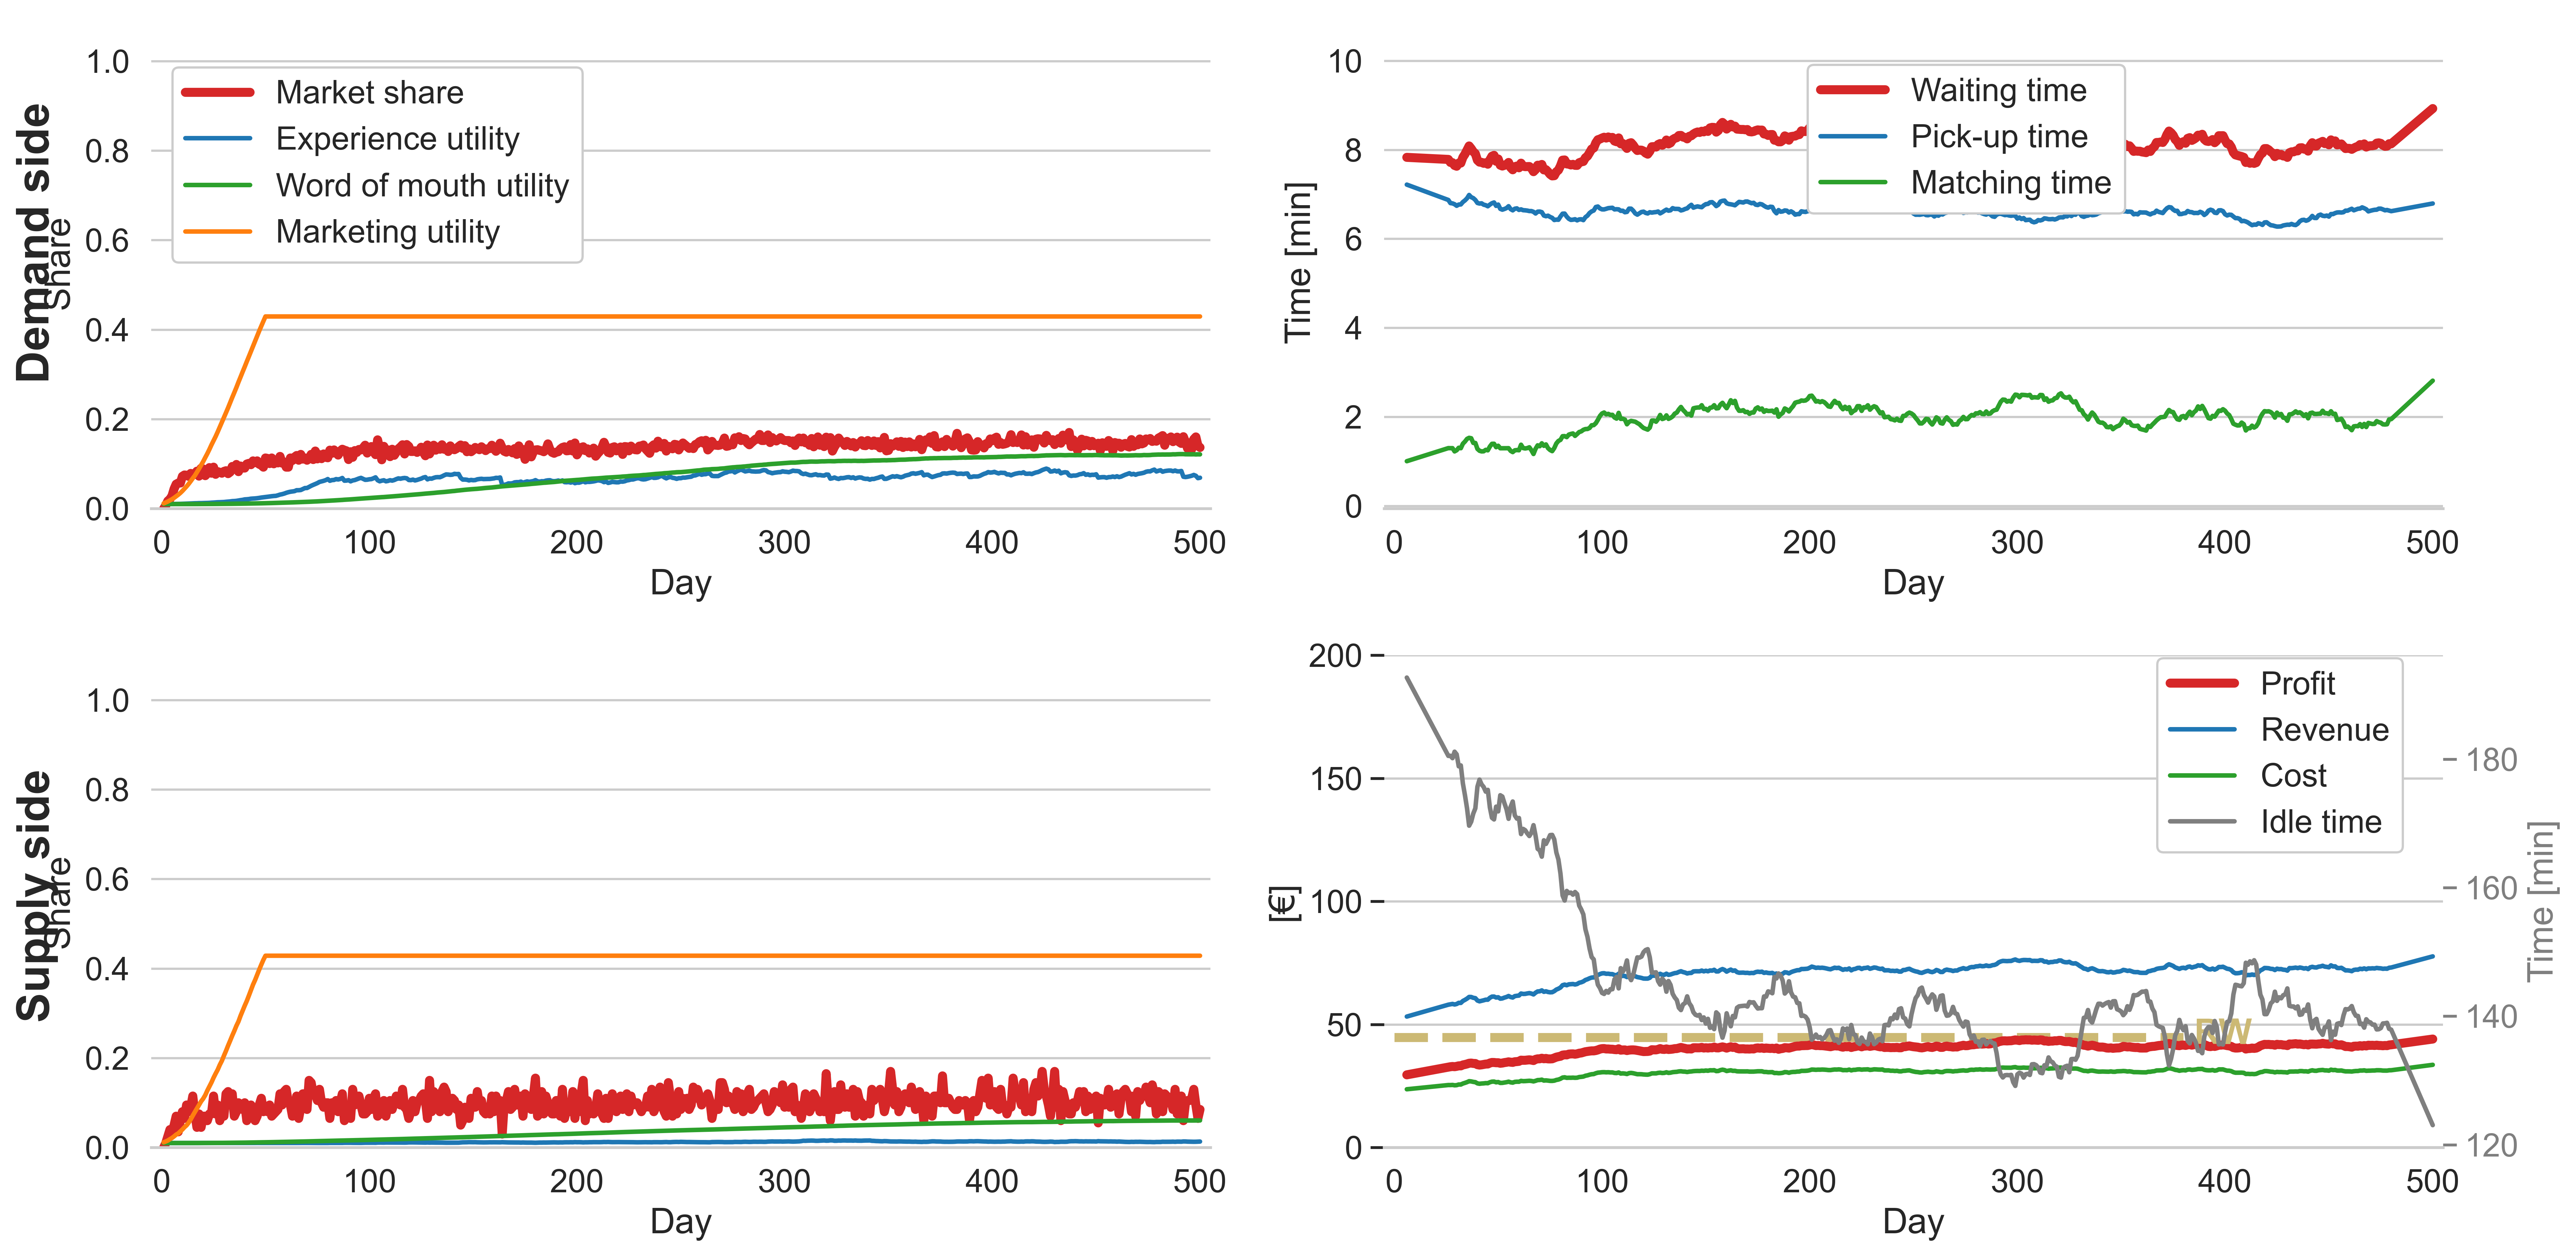

In [9]:
sns.set(rc={"figure.dpi":500, 'savefig.dpi':500})
sns.set(palette='tab10',font_scale=1.3)#, rc={'axes.facecolor':'lightblue', 'figure.facecolor':'lightgreen'},)
sns.set_style('whitegrid')
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(16,8))
# plt.subplots_adjust(wspace=0.3, hspace=0.4)
sns.despine(left=True)
d1 = pd.DataFrame()


for ax_n in [0,1]:
    
    x = []; ye = []; ym = []; yw = []; yms = []
    if ax_n==0:
        for d in range(0,sim.params.nD):
            yw.append(sim.res[d].pax_exp.WOM_U.mean())
            ym.append(sim.res[d].pax_exp.MARKETING_U.mean())
            ye.append(sim.res[d].pax_exp.EXPERIENCE_U.mean())
            yms.append(sim.res[d].pax_exp.OUT.value_counts().get(False, 0)/params.nP)
        d1['P_WOM_U'] = yw; d1['P_MARKETING_U'] = ym
        d1['P_EXPERIENCE_U'] = ye; d1['P_SHARE'] = yms
            
    if ax_n==1:
        for d in range(0,sim.params.nD):
            yw.append(sim.res[d].veh_exp.WOM_U.mean())
            ym.append(sim.res[d].veh_exp.MARKETING_U.mean())
            ye.append(sim.res[d].veh_exp.EXPERIENCE_U.mean())
            yms.append(sim.res[d].veh_exp.OUT.value_counts().get(False, 0)/params.nV)
        d1['V_WOM_U'] = yw; d1['V_MARKETING_U'] = ym
        d1['V_EXPERIENCE_U'] = ye; d1['V_SHARE'] = yms
    
    lx = [i for i in range(1,len(ye)+1)]
    sns.lineplot(x=lx, y=yms, label = 'Market share', color='C3', lw=4, ax=ax[ax_n][0])
    sns.lineplot(x=lx, y=ye, label = 'Experience utility', color='C0', lw=2, ax=ax[ax_n][0])
    sns.lineplot(x=lx, y=yw, label = 'Word of mouth utility', color='C2', lw=2, ax=ax[ax_n][0])
    sns.lineplot(x=lx, y=ym, label = 'Marketing utility', color='C1', lw=2, ax=ax[ax_n][0])
   
    # ax[ax_n][0].vlines([100], 0, 1.1, linestyles='dashed', colors='black')
    ax[ax_n][0].grid(axis='x')
    ax[ax_n][0].set(xlabel='Day', ylabel='Share', ylim=(0,1.1),  xlim=(-5,sim.params.nD+5))
    
# ax[0][0].set_title('Demand side',fontweight='bold', loc='center',fontsize=20);ax[0][1].set_title('Supply side',fontweight='bold', loc='center',fontsize=20)
ax[0][0].legend(frameon=True,framealpha=1, loc=(0.02,0.5))#,  bbox_to_anchor=(0.75, 1.24), ncol=4)
ax[1][0].get_legend().set_visible(False)

#===============================================================================================

x = []; yw = []; yp = []; yi = []; ym = []; yr = []; yprof = []; yc = []

for d in range(0,sim.params.nD):
    df = sim.res[d].pax_exp
    yw.append(df[df.OUT==False].ACTUAL_WT.mean()) # Waiting time per passenger
    ym.append(df[df.OUT==False].MATCHING_T.mean()) # Matching time per passenger
    # yprof.append(df.plat_profit.sum())
    
    df = sim.res[d].veh_exp
    yp.append(df[df.OUT==False].ARRIVES_AT_PICKUP.mean()/(df[df.OUT==False].nRIDES.mean()*60))
    yi.append(df[df.OUT==False].IDLE_TIME.mean()/60)
    yr.append(df[df.OUT==False].REVENUE.mean())
    yprof.append(df[df.OUT==False].ACTUAL_INC.mean())
    yc.append(df[df.OUT==False].COST.mean())

yw = smooth(yw); ym = smooth(ym); yp = smooth(yp); yi = smooth(yi)
yr = smooth(yr); yprof = smooth(yprof); yc = smooth(yc)

d2 = pd.DataFrame()
d2['yw'] = yw; d2['ym'] = ym; d2['yp'] = yp; d2['yi'] = yi
d2['yr'] = yr; d2['yprof'] = yprof; d2['yc'] = yc

x = [i for i in range(1,len(yp)+1)]
sns.lineplot(x=x, y=yw, label = 'Waiting time', color='C3',lw=4, ax=ax[0][1])#, marker='o')
sns.lineplot(x=x, y=yp, label = 'Pick-up time', color='C0',lw=2, ax=ax[0][1])#, marker='o')
sns.lineplot(x=x, y=ym, label = 'Matching time', color='C2',lw=2, ax=ax[0][1])#, marker='o')
sns.lineplot(x=x, y=yprof, label = 'Profit', color='C3',lw=4, ax=ax[1][1])#, marker='o')
sns.lineplot(x=x, y=yr, label = 'Revenue', color='C0',lw=2, ax=ax[1][1])#, marker='o')
sns.lineplot(x=x, y=yc, label = 'Cost', color='C2',lw=2, ax=ax[1][1])#, marker='o')ax.twinx()
ax11 = ax[1][1].twinx()
sns.lineplot(x=x, y=yi, label = 'Idle time', color='C7',lw=2, ax=ax11)#, marker='o')
ax11.set(ylabel='Time [min]')
ax11.grid(b=None)

lines, labels = ax[1][1].get_legend_handles_labels()
lines2, labels2 = ax11.get_legend_handles_labels()
ax[1][1].legend(lines + lines2, labels + labels2,framealpha=1, loc=(0.73,0.6))
ax11.legend().remove()
# ax11.spines['right'].set_color('C7')
ax11.tick_params(axis='y', colors='C7')
ax11.yaxis.label.set_color('C7')

for i in [0,1]:
    ax[i][1].grid(axis='x')

# ax[0][1].vlines([100], 0, 11, linestyles='dashed', colors='black')
# ax[1][1].vlines([100], 0, 110, linestyles='dashed', colors='black')
ax[1][1].hlines([params.d2d.res_wage], 0, 380, linestyles='dashed', colors='y', lw=4)
ax[1][1].annotate('RW', xy =(385,42), fontweight='bold', color='y')
  
    
ax[0][1].set(xlabel='Day', ylabel='Time [min]', ylim=(-0.06,11), xlim=(-5,sim.params.nD+5)); ax[1][1].set(xlabel='Day', ylabel='[€]', ylim=(0,200),xlim=(-5,sim.params.nD+5))
ax[0][1].legend(loc=(0.4,0.6),framealpha=1)

ax[0][0].text(x=-70 ,y=0.3, s='Demand side',fontweight='bold',fontsize=20, rotation=90)
ax[1][0].text(x=-70 ,y=0.3, s='Supply side',fontweight='bold',fontsize=20, rotation=90)
sns.despine(left=True)


plt.tight_layout()
# plt.savefig('Fig1x.png')

### Results analysis

In [7]:
df10 = pd.read_csv('competition_csv/demand_comm_0.2_fare_1.0.csv')
df12 = pd.read_csv('competition_csv/demand_comm_0.2_fare_1.2.csv')
df14 = pd.read_csv('competition_csv/demand_comm_0.2_fare_1.4.csv')
df16 = pd.read_csv('competition_csv/demand_comm_0.2_fare_1.6.csv')
df18 = pd.read_csv('competition_csv/demand_comm_0.2_fare_1.8.csv')
df20 = pd.read_csv('competition_csv/demand_comm_0.2_fare_2.0.csv')

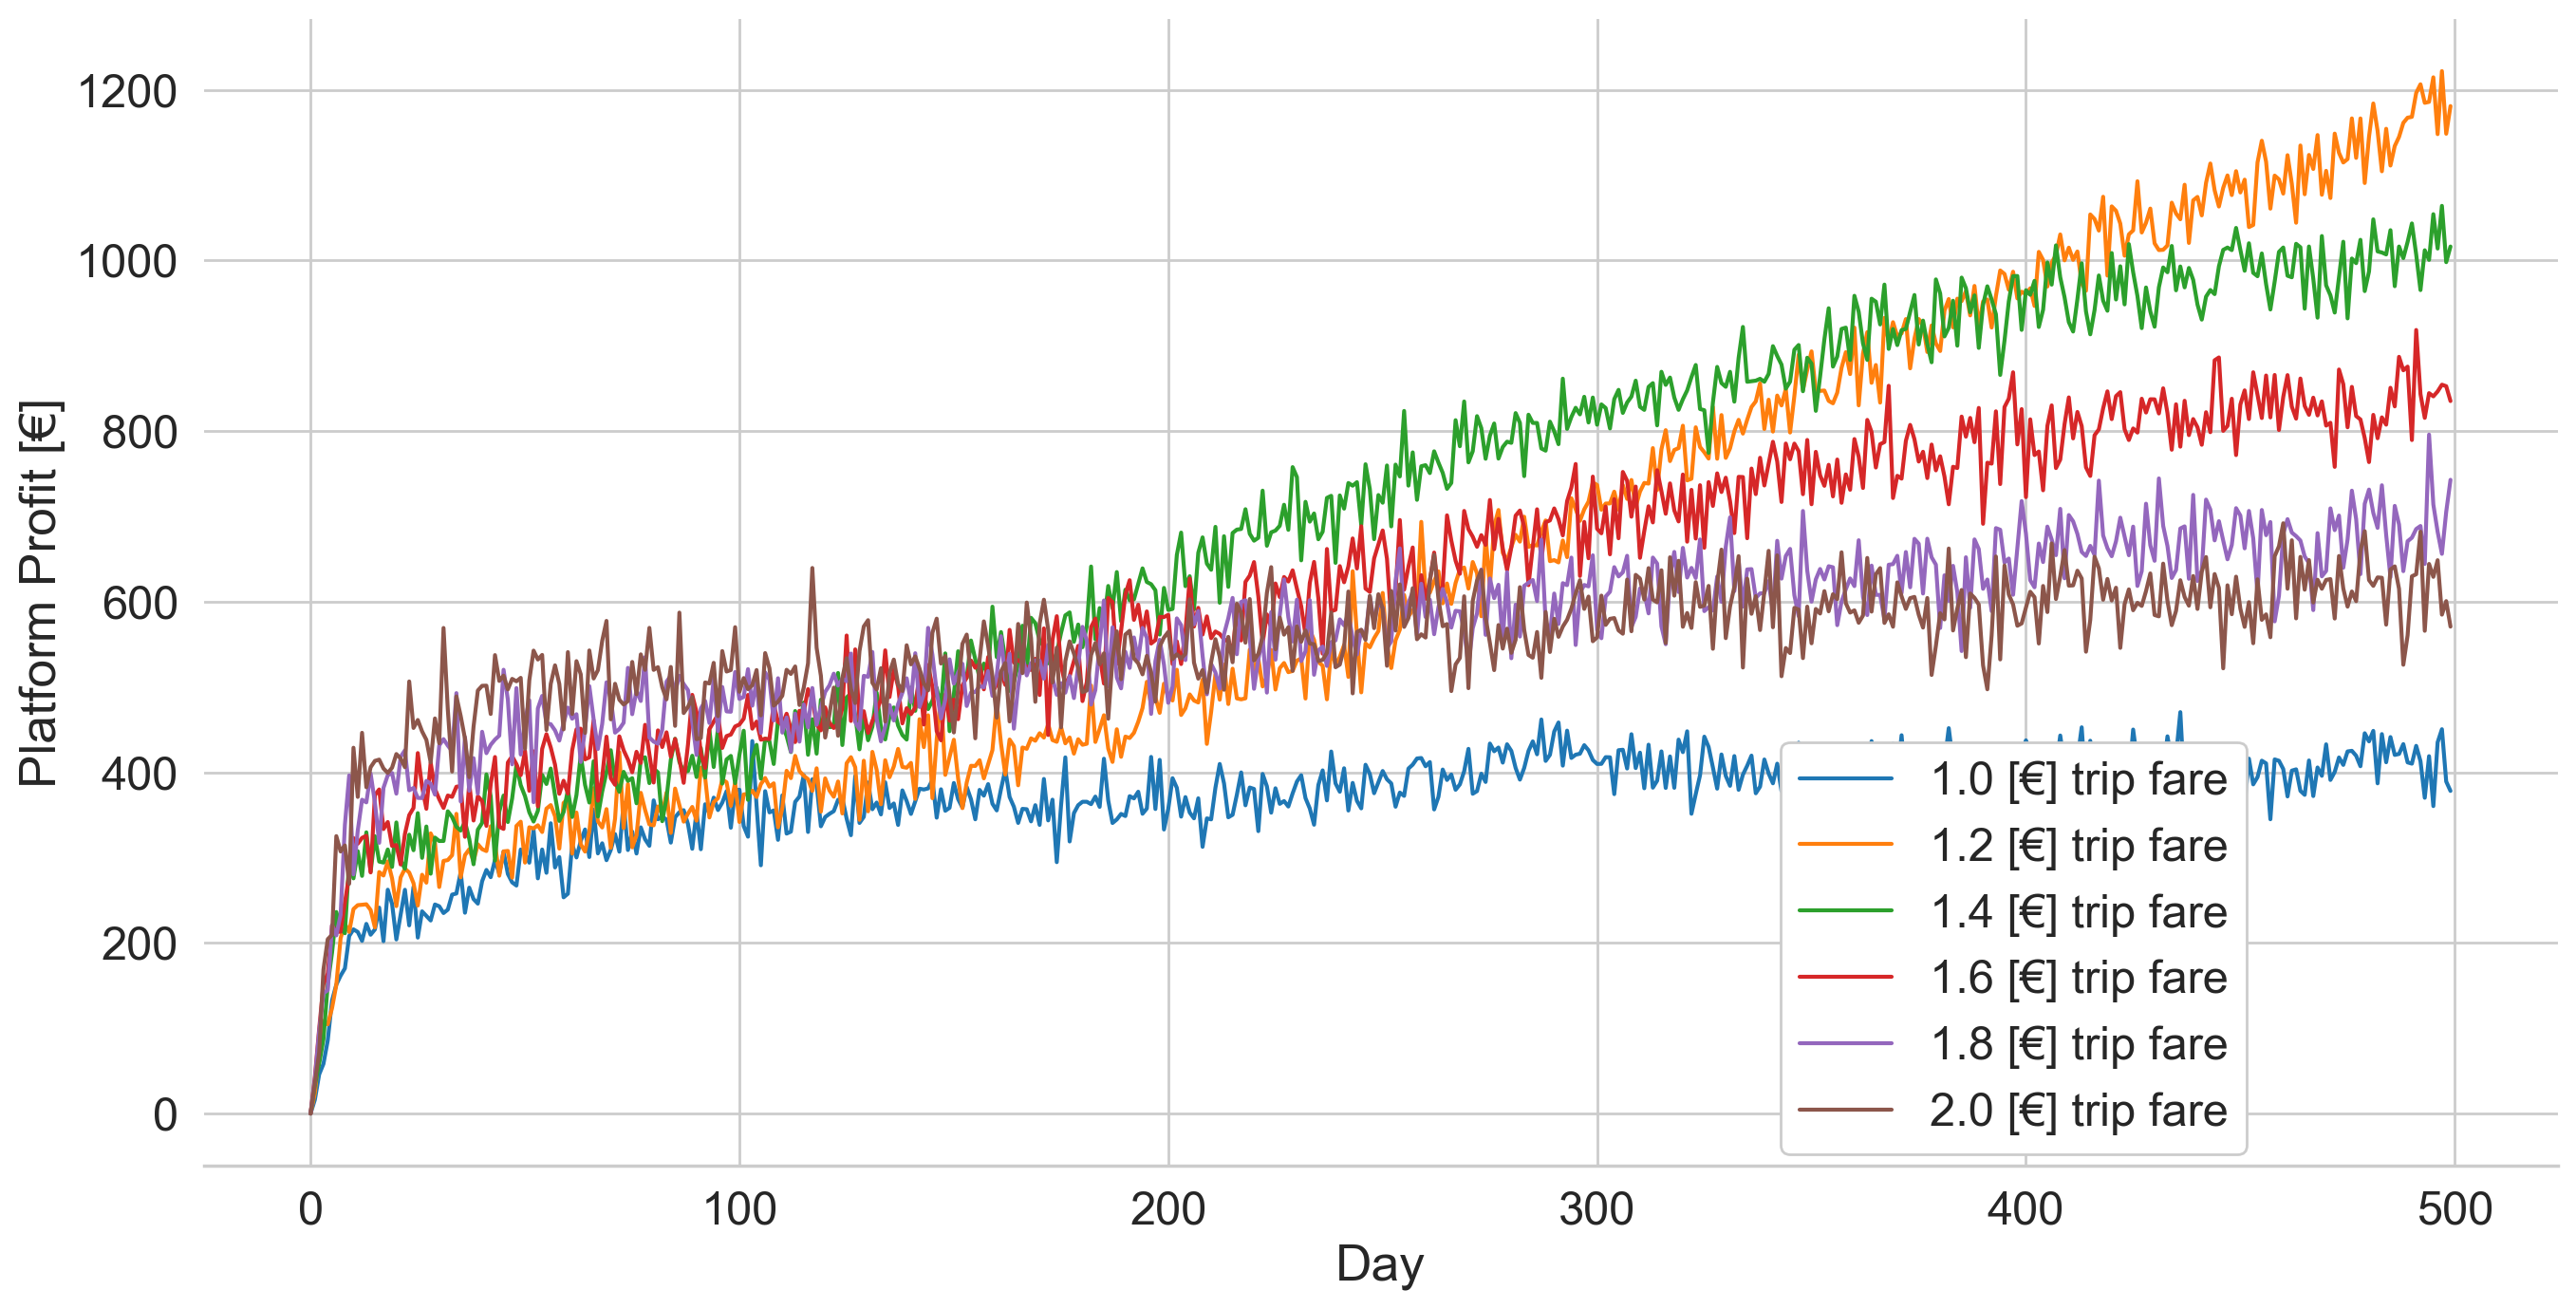

In [8]:
sns.set(rc={"figure.dpi":200, 'savefig.dpi':200})
sns.set(palette='tab10',font_scale=1.6)#, rc={'axes.facecolor':'lightblue', 'figure.facecolor':'lightgreen'},)
sns.set_style('whitegrid')
fig, ax = plt.subplots(nrows=1, figsize=(16,8))
sns.despine(left=True)

sns.lineplot(x=df10.index, y=df10.plat_revenue, label='1.0 [€] trip fare')
sns.lineplot(x=df12.index, y=df12.plat_revenue, label='1.2 [€] trip fare')
sns.lineplot(x=df14.index, y=df14.plat_revenue, label='1.4 [€] trip fare')
sns.lineplot(x=df16.index, y=df16.plat_revenue, label='1.6 [€] trip fare')
sns.lineplot(x=df18.index, y=df18.plat_revenue, label='1.8 [€] trip fare')
sns.lineplot(x=df20.index, y=df20.plat_revenue, label='2.0 [€] trip fare')

ax.set(xlabel='Day', ylabel='Platform Profit [€]')
ax.legend(frameon=True,framealpha=1, loc=(0.67,0.01))

[Text(0.5, 0, 'Day'), Text(0, 0.5, 'Platform Profit [€]')]

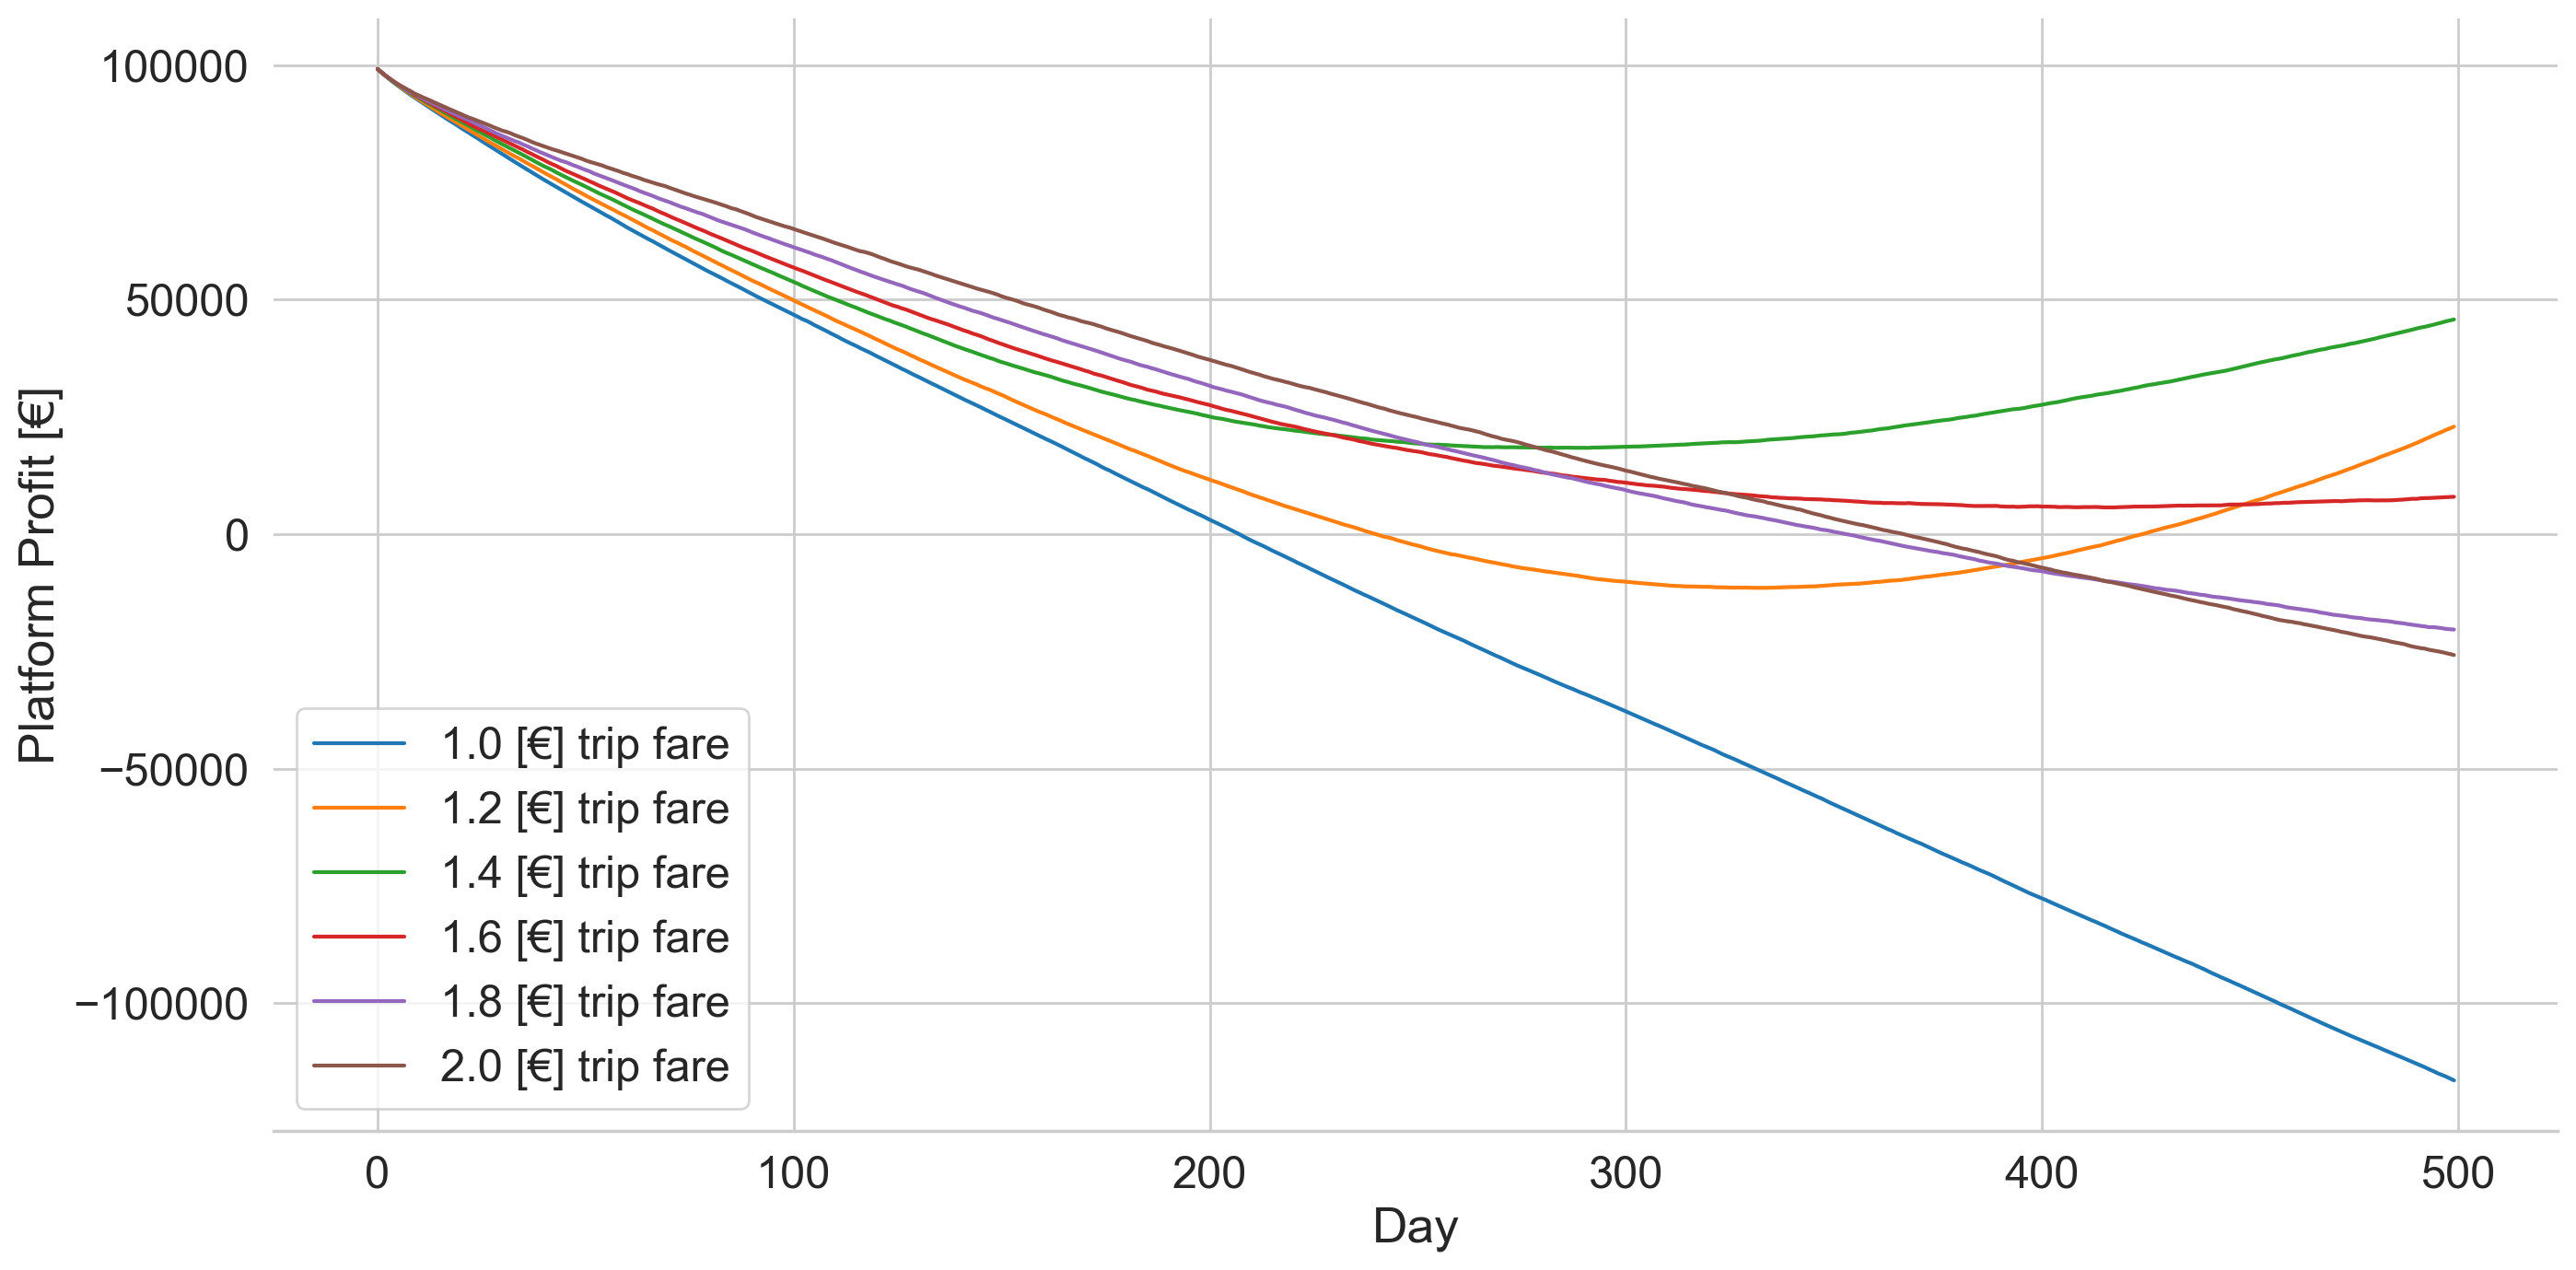

In [27]:
sns.set(rc={"figure.dpi":200, 'savefig.dpi':200})
sns.set(palette='tab10',font_scale=1.6)#, rc={'axes.facecolor':'lightblue', 'figure.facecolor':'lightgreen'},)
sns.set_style('whitegrid')
fig, ax = plt.subplots(nrows=1, figsize=(16,8))
sns.despine(left=True)

initial_capital = 100000
expense_per_day = 800 # euro

# 70000, 800

df10['daily_profit'] = df10.plat_revenue-expense_per_day
df10['remaining_capital'] = initial_capital + (df10.daily_profit.cumsum())

df12['daily_profit'] = df12.plat_revenue-expense_per_day
df12['remaining_capital'] = initial_capital + (df12.daily_profit.cumsum())

df14['daily_profit'] = df14.plat_revenue-expense_per_day
df14['remaining_capital'] = initial_capital + (df14.daily_profit.cumsum())

df16['daily_profit'] = df16.plat_revenue-expense_per_day
df16['remaining_capital'] = initial_capital + (df16.daily_profit.cumsum())

df18['daily_profit'] = df18.plat_revenue-expense_per_day
df18['remaining_capital'] = initial_capital + (df18.daily_profit.cumsum())

df20['daily_profit'] = df20.plat_revenue-expense_per_day
df20['remaining_capital'] = initial_capital + (df20.daily_profit.cumsum())


sns.lineplot(x=df10.index, y=df10.remaining_capital, label='1.0 [€] trip fare')
sns.lineplot(x=df12.index, y=df12.remaining_capital, label='1.2 [€] trip fare')
sns.lineplot(x=df14.index, y=df14.remaining_capital, label='1.4 [€] trip fare')
sns.lineplot(x=df16.index, y=df16.remaining_capital, label='1.6 [€] trip fare')
sns.lineplot(x=df18.index, y=df18.remaining_capital, label='1.8 [€] trip fare')
sns.lineplot(x=df20.index, y=df20.remaining_capital, label='2.0 [€] trip fare')

ax.set(xlabel='Day', ylabel='Platform Profit [€]')
# ax.legend(frameon=True,framealpha=1, loc=(0.67,0.01))

Two platforms are competing with separate pools of travelers and drivers (no multi-homing).
Initial capital = 100000 [€] & Platform expenses = 800 [€/day]


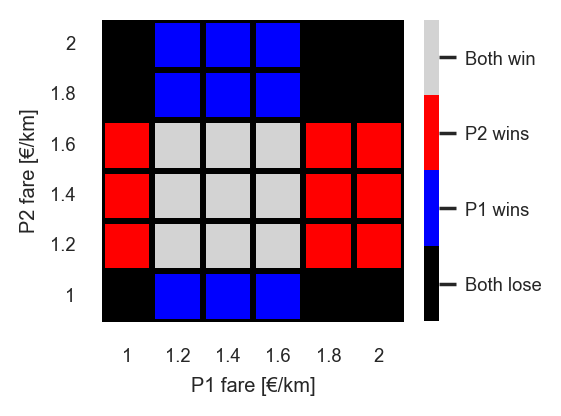

In [28]:
sns.set(rc={"figure.dpi":200, 'savefig.dpi':200})
plt.figure(figsize=(2.5, 2))
sns.set(palette='tab10',font_scale=0.6)

# Create a 6x6 grid
grid_size = 6
grid = np.zeros((grid_size, grid_size))

values = {0: df10, 1: df12, 2: df14, 3: df16, 4: df18, 5: df20}

# Define a condition for coloring the cells
for i in range(grid_size):
    for j in range(grid_size):
        p2 = values[i].iloc[-1].remaining_capital
        p1 = values[j].iloc[-1].remaining_capital
        
        if p1<0 and p2<0:
            grid[i, j] = 0
        elif p1>0 and p2>0:
            grid[i, j] = 3
        elif p1>0 and p2<0:
            grid[i, j] = 1
        elif p1<0 and p2>0:
            grid[i, j] = 2


grid = grid[::-1]
    
# Convert the data to a DataFrame
grid_df = pd.DataFrame(grid)

# Create a color palette: 0 -> white, 1 -> blue
cmap = sns.color_palette(["black", "blue", "red", "lightgrey"])

# Plot the grid
ax = sns.heatmap(grid_df, cmap=cmap, vmin=0, vmax=3, cbar=True, square=True, linewidths=2, linecolor='black')
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([0.375, 1.125, 1.875, 2.625])
colorbar.set_ticklabels(['Both lose', 'P1 wins', 'P2 wins', 'Both win'])

# Set ticks to match the grid lines
xticks = [1, 1.2, 1.4, 1.6, 1.8, 2]
plt.xticks(ticks=np.arange(0.5, grid_size), labels=xticks, rotation=0)

yticks = xticks[::-1]
plt.yticks(ticks=np.arange(0.5, grid_size), labels=yticks, rotation=0)

plt.xlabel('P1 fare [€/km]')
plt.ylabel('P2 fare [€/km]')

print('Two platforms are competing with separate pools of travelers and drivers (no multi-homing).')
print('Initial capital = {} [€] & Platform expenses = {} [€/day]'.format(initial_capital,expense_per_day)) 
plt.show()